In [247]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder, StandardScaler
    
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score, confusion_matrix, precision_score, f1_score, accuracy_score, classification_report

In [221]:
# Importing the dataset
df = pd.read_csv('telco_churn.csv')
df.head()
df.dtypes


#this you can cancel
df.drop(df[df['TotalCharges'] == " "].index, inplace=True)
#since it's a numerical feature, we need to convert it to a float dtype
df['TotalCharges'] = df['TotalCharges'].astype(float)
#we also want to drop the customerID column, which we won't need for our analysis
df.drop(['customerID'], axis=1, inplace=True)
df['OnlineServices'] = df['OnlineSecurity'] +  df['OnlineBackup']
df['OnlineServices'] = df['OnlineServices'].replace({'NoNo': 'No Online Service',
                                                       'YesNo': 'Only Security',
                                                       'NoYes': 'Only Backup',
                                                       'YesYes': 'Both Services',
                                                       'No internet serviceNo internet service':'No internet service'})
df.drop(['OnlineSecurity', 'OnlineBackup'], axis=1, inplace=True)
df['StreamingServices'] = df['StreamingTV'] +  df['StreamingMovies']
df['StreamingServices'] = df['StreamingServices'].replace({'NoNo': 'No Streaming Service', 
                                                         'YesNo': 'Only TV', 
                                                         'NoYes': 'Only Movies', 
                                                         'YesYes': 'Both Services',
                                                         'No internet serviceNo internet service':'No internet service'})
df.drop(['StreamingTV', 'StreamingMovies'], axis=1, inplace=True)

In [ ]:
#gives us us shape, dtypes, and also null values
df.info() 

In [ ]:
df[df['TotalCharges'] == " "]

In [214]:
df.drop(df[df['TotalCharges'] == " "].index, inplace=True)
#since it's a numerical feature, we need to convert it to a float dtype
df['TotalCharges'] = df['TotalCharges'].astype(float)

In [215]:
#we also want to drop the customerID column, which we won't need for our analysis
df.drop(['customerID'], axis=1, inplace=True)


In [ ]:
#first, we want to look at numerical features
num_feat = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[num_feat].describe()

In [ ]:
#plotting distributions of numerical variables divided by churn 
fig, ax  = plt.subplots(1, 3, figsize=(18, 6))

ax0 = sns.kdeplot(x = df['MonthlyCharges'],  hue= df['Churn'], ax= ax[0],  fill=True)
ax0.set(xlabel= 'Monthly Charges', ylabel= 'Frequency')

ax1 = sns.kdeplot(x = df['TotalCharges'], hue= df['Churn'], ax= ax[1],   fill=True)
ax1.set(xlabel= 'Total Charges', ylabel= 'Frequency')

ax2 = sns.kdeplot(x = df['tenure'], hue= df['Churn'], ax= ax[2],  fill=True)
ax2.set(xlabel= 'Tenure', ylabel= 'Frequency')

plt.tight_layout()
plt.show()

In [ ]:
#it'd be interesting to see how monthly charges compare to total charges
plt.figure(figsize=(20,9))
plt.scatter(x = df['MonthlyCharges'],y=df['TotalCharges'],s=10)
plt.xlabel('MonthlyCharges')
plt.ylabel('TotalCharges')
plt.title('MonthlyCharges vs TotalCharges Scatter Plot')
plt.show()

In [ ]:
#we can visually see there is a high correlation. let's see it quantitatively between all variables
plt.figure(figsize=(8, 8))
sns.heatmap(df[num_feat].corr(), annot = True, square=True)
plt.show()

In [ ]:
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies']

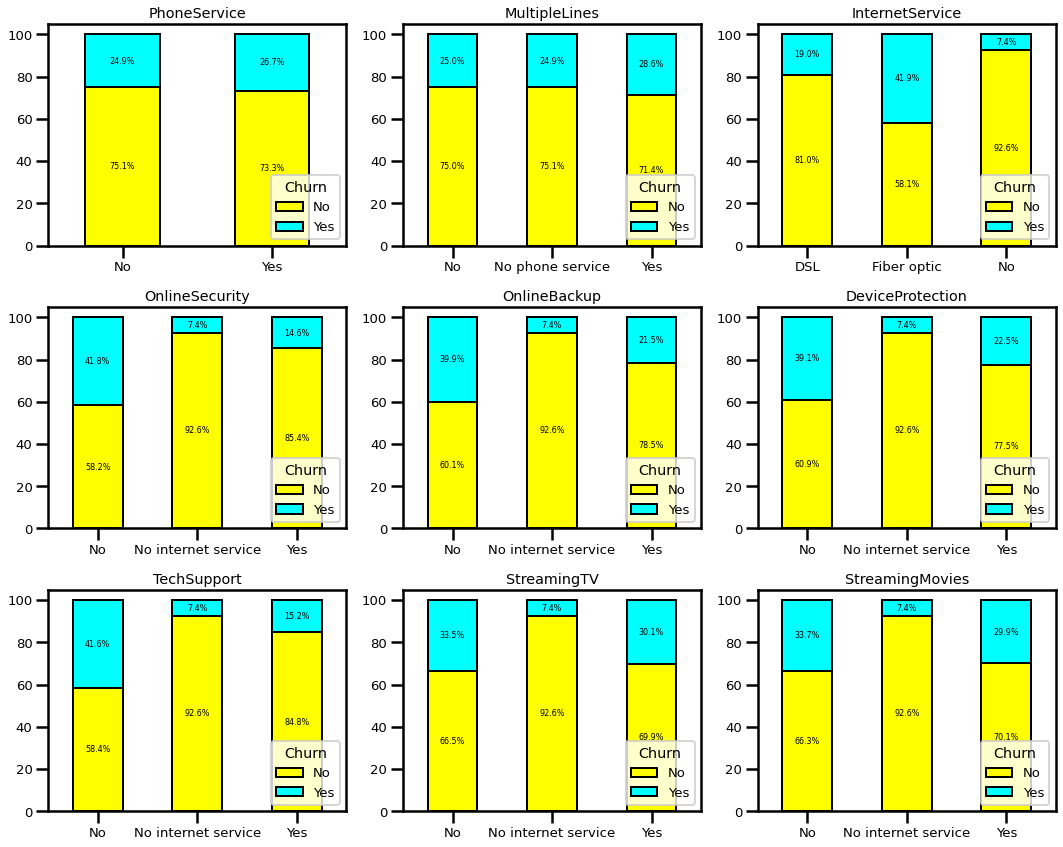

In [147]:
fig, axes = plt.subplots(nrows = 3,ncols = 3,figsize = (15,12))
for i, item in enumerate(services[:3]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['yellow', 'cyan'], edgecolor='black', ax=axes[0,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
for i, item in enumerate(services[3:6]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['yellow', 'cyan'], edgecolor='black', ax=axes[1,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
for i, item in enumerate(services[6:9]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['yellow', 'cyan'], edgecolor='black', ax=axes[2,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')

plt.tight_layout()
plt.show()

In [216]:
#from the barplots we can see that online sec and online back have very similar percentages,
#and since they relate to services that would usually be bought together it makes sense to 
#merge them into one variable
df['OnlineServices'] = df['OnlineSecurity'] +  df['OnlineBackup']
df['OnlineServices'] = df['OnlineServices'].replace({'NoNo': 'No Online Service',
                                                       'YesNo': 'Only Security',
                                                       'NoYes': 'Only Backup',
                                                       'YesYes': 'Both Services',
                                                       'No internet serviceNo internet service':'No internet service'})
df.drop(['OnlineSecurity', 'OnlineBackup'], axis=1, inplace=True)

In [217]:
#same thing we can do with StreamingTV and StreamingMovies
df['StreamingServices'] = df['StreamingTV'] +  df['StreamingMovies']
df['StreamingServices'] = df['StreamingServices'].replace({'NoNo': 'No Streaming Service', 
                                                         'YesNo': 'Only TV', 
                                                         'NoYes': 'Only Movies', 
                                                         'YesYes': 'Both Services',
                                                         'No internet serviceNo internet service':'No internet service'})
df.drop(['StreamingTV', 'StreamingMovies'], axis=1, inplace=True)

In [134]:
# now let's look at demographic categorical variables
demographic = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

In [ ]:
fig, axes = plt.subplots(nrows = 2,ncols = 2,figsize = (8,8))
for i, item in enumerate(demographic[:2]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['yellow', 'cyan'], edgecolor='black', ax=axes[0,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
for i, item in enumerate(demographic[2:4]):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['yellow', 'cyan'], edgecolor='black', ax=axes[1,i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')
plt.tight_layout()
plt.show()

In [138]:
# now let's look at demographic categorical variables
payment = ['Contract', 'PaperlessBilling', 'PaymentMethod']

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 3,figsize = (15,5))
for i, item in enumerate(payment):
    contract_churn_percent = df.groupby([item, 'Churn']).size() / df.groupby(item).size() * 100
    pivot_df = contract_churn_percent.unstack()
    ax = pivot_df.plot(kind='bar', stacked=True, color=['yellow', 'cyan'], edgecolor='black', ax=axes[i], rot=0)
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        ax.annotate(f'{height:.1f}%', (x + width / 2, y + height / 2), ha='center', va='center', fontsize=8)
        ax.set_title(item)
        ax.set_xlabel('')
        ax.legend(title='Churn',loc='lower right')

plt.tight_layout()
plt.show()

In [207]:
unique_values = {column: list(df[column].unique()) for column in df.select_dtypes(object).columns}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female', 'Male']
Partner : ['Yes', 'No']
Dependents : ['No', 'Yes']
PhoneService : ['No', 'Yes']
MultipleLines : ['No phone service', 'No', 'Yes']
InternetService : ['DSL', 'Fiber optic', 'No']
DeviceProtection : ['No', 'Yes', 'No internet service']
TechSupport : ['No', 'Yes', 'No internet service']
Contract : ['Month-to-month', 'One year', 'Two year']
PaperlessBilling : ['Yes', 'No']
PaymentMethod : ['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)']
Churn : ['No', 'Yes']
OnlineServices : ['Only Backup', 'Only Security', 'Both Services', 'No Service', 'No internet service']
StreamingServices : ['No Service', 'Both Services', 'Only TV', 'No internet service', 'Only Movies']


In [222]:
# we use binary encoding where there are 2 categories, otherwise one hot encoding. you can add ordinal encoding if you want to get fancy
le = LabelEncoder()
for col in df.select_dtypes(object).columns:
    if df[col].nunique() == 2:
        df[col] = le.fit_transform(df[col])
    else:
        dummies = pd.get_dummies(df[col], drop_first= True)
        df = pd.concat([df, dummies], axis=1)
        df.drop(col,axis =1 , inplace= True)
    

In [226]:
X = df.drop('Churn', axis= 1)
y = df['Churn']

In [228]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [229]:
#test size and random state to be investigated
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, stratify= y, random_state= 42) 

In [230]:
print(y_train.value_counts())
print(y_test.value_counts())

0    4130
1    1495
Name: Churn, dtype: int64
0    1033
1     374
Name: Churn, dtype: int64


In [231]:
knn_model = KNeighborsClassifier(n_neighbors = 11) 
knn_model.fit(X_train,y_train)
predicted_y = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test,y_test)
print("KNN accuracy:",accuracy_knn)

KNN accuracy: 0.7569296375266524


In [233]:
print(classification_report(y_test, predicted_y))

              precision    recall  f1-score   support

           0       0.84      0.83      0.83      1033
           1       0.54      0.55      0.55       374

    accuracy                           0.76      1407
   macro avg       0.69      0.69      0.69      1407
weighted avg       0.76      0.76      0.76      1407



In [237]:
svc_model = SVC(random_state = 1)
svc_model.fit(X_train,y_train)
predict_y = svc_model.predict(X_test)
accuracy_svc = svc_model.score(X_test,y_test)
print("SVM accuracy is :",accuracy_svc)
print(classification_report(y_test, predict_y))

SVM accuracy is : 0.7903340440653873
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1033
           1       0.63      0.50      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407



In [ ]:
model_rf = RandomForestClassifier(n_estimators=500 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)
print (accuracy_score(y_test, prediction_test))

In [ ]:
print(classification_report(y_test, prediction_test))

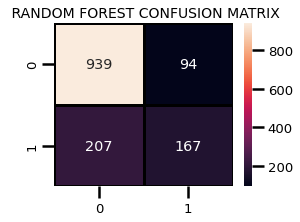

In [242]:
plt.figure(figsize=(4,3))
sns.heatmap(confusion_matrix(y_test, prediction_test),
                annot=True,fmt = "d",linecolor="k",linewidths=3)
    
plt.title(" RANDOM FOREST CONFUSION MATRIX",fontsize=14)
plt.show()

In [244]:
models = {
    'logistic regression' : LogisticRegression(),
    'gradient boosing' : GradientBoostingClassifier(),
    'naive bayes' : GaussianNB(),
    'random forest' : RandomForestClassifier()
}
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')
results = {}

kf = KFold(n_splits= 10)

for name, model in models.items():
    result = cross_val_score(model, X_train, y_train, scoring= 'roc_auc', cv= kf)
    results[name] = result
for name, result in results.items():
    print("----------------")
    print(f'{name} : {np.mean(result)}')

logistic regression trained
gradient boosing trained
naive bayes trained
random forest trained
----------------
logistic regression : 0.8474747078309726
----------------
gradient boosing : 0.8478174091024023
----------------
naive bayes : 0.8183538511590754
----------------
random forest : 0.8277090764357343


In [246]:
models = {
    'logistic regression' : LogisticRegression(),
    'gradient boosing' : GradientBoostingClassifier(),
    'naive bayes' : GaussianNB(),
    'random forest' : RandomForestClassifier()
}
for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} trained')
results = {}

kf = StratifiedKFold(n_splits= 10)

for name, model in models.items():
    result = cross_val_score(model, X_train, y_train, scoring= 'roc_auc', cv= kf)
    results[name] = result
for name, result in results.items():
    print("----------------")
    print(f'{name} : {np.mean(result)}')

logistic regression trained
gradient boosing trained
naive bayes trained
random forest trained
----------------
logistic regression : 0.8468879102545351
----------------
gradient boosing : 0.8482480621414759
----------------
naive bayes : 0.817905466088153
----------------
random forest : 0.825259014901604


In [254]:
    # tol = trial.suggest_loguniform('tol', 1e-7, 0.1)
    # C = trial.suggest_float('C', 0, 0.1)
    # max_iter = trial.suggest_int('max_iter', 50, 600)
    # penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])

parameters = {'C':[1, 10]}
lr = LogisticRegression()
clf = GridSearchCV(lr, parameters, scoring='accuracy', cv=5)
clf = clf.fit(X_train, y_train)
print(clf.best_params_)
print(clf.best_score_)

{'C': 1}
0.8024888888888888
